## 필요한 모듈 설치 확인

In [1]:
!python3 -c 'import numpy'
!python3 -c 'import matplotlib'
!python3 -c 'import seaborn'
!python3 -c 'import torch'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
sns.set()
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn.functional as F

# GPU 사용 여부 확인
USE_GPU = torch.cuda.is_available()
print(USE_GPU)

True


## 학습 데이터 만들기

In [3]:
x = np.linspace(-3, 3, 300)
x_ = np.linspace(-3,3, 300)

f = lambda x : x**2

x = np.linspace(-3,3,300)
mean_list = f(x)
y = f(x) + np.random.uniform(low=-1.0,high=1.0,size=x.shape)* 4* np.cos(x/2+.5)

y_ = -y
x = np.concatenate((x,x), axis=0)
y = np.concatenate((y,y_),axis =0)

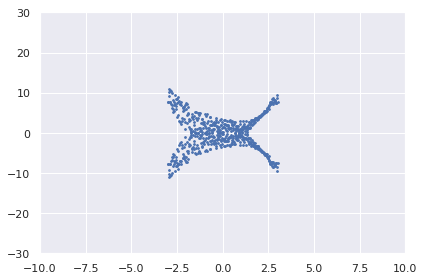

In [4]:
plt.xlim(-10,10)
plt.ylim(-30,30)
plt.scatter(x, y,s=3)
plt.tight_layout()
plt.show()

## 생성자와 판별자 정의하기

In [5]:
# 생성자 정의하기
class G(nn.Module):
    def __init__(self,hidden_size=50, noise_dim=5):
        super().__init__()
        # 생성자 구조 정의
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        self.noise_dim = noise_dim
        self.fc1 = nn.Linear(1,hidden_size,bias=False) 
        self.fc_noise = nn.Linear(self.noise_dim,hidden_size,bias=False)
        self.concate_layer_bias = nn.Parameter(torch.zeros(hidden_size))
        if USE_GPU:
            self.concate_layer_bias.cuda()
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        
        # 생성자 가중치 초기화
        self.fc1.weight.data.normal_(0,0.02)
        self.fc_noise.weight.data.normal_(0,0.02)
        self.fc2.weight.data.normal_(0,0.02)
        nn.init.constant_(self.fc2.bias, 0.0)
        self.out.weight.data.normal_(0,0.02)
        nn.init.constant_(self.out.bias, 0.0)
        
    def forward(self, input, num_particle=10):
        n_dims = input.dim() # 2
        sample_shape = list(input.shape) # N * in_dim
        sample_shape[n_dims-1:] = (num_particle, self.noise_dim) # N * n_part * obs_dim
        sample_shape = torch.Size(list(sample_shape))
        
        expanded_inputs = []
        input_expanded = input.unsqueeze(n_dims-1) # N * 1 * obs_dim
        expanded_inputs.append(input_expanded)
        xi = torch.randn(sample_shape) # N * n_part * obs_dim
        if USE_GPU:
            xi = xi.cuda()
        expanded_inputs.append(Variable(xi))
        
        # 입력 레이어와 노이즈 레이어를 더하기
        concate_layers = [self.fc1, self.fc_noise]
        result = self.concate_layer_bias
        # hidden_size
        for var, layer in zip(expanded_inputs, concate_layers):
            result = result + layer(var) # N * n_part * hidden_size
        
        result = self.lrelu(result)
        result = self.lrelu(self.fc2(result)) # N * n_part * hidden_size
        out = self.out(result) # N * n_part * out_dim
        return out

In [6]:
# 판별자 정의하기
class D(nn.Module):
    def __init__(self,hidden_size=50):
        super().__init__()
        # 판별자 구조 정의
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        self.fc_in = nn.Linear(1, hidden_size,bias=False)
        self.fc_out = nn.Linear(1, hidden_size,bias=False)
        self.concate_layer_bias = nn.Parameter(torch.zeros(hidden_size))
        if USE_GPU:
            self.concate_layer_bias.cuda()
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        
        # 판별자 가중치 초기화
        self.fc_in.weight.data.normal_(0,0.02)
        self.fc_out.weight.data.normal_(0,0.02)
        self.fc2.weight.data.normal_(0,0.02)
        nn.init.constant_(self.fc2.bias, 0.0)
        self.out.weight.data.normal_(0,0.02)
        nn.init.constant_(self.out.bias, 0.0)
        
    def forward(self, input, output):
        # input/output은 생성자의 입력/출력
        # 판별자의 리턴값은 unnoramlized log-prob
        
        expanded_inputs = []
        expanded_inputs.append(input.unsqueeze(-1))
        expanded_inputs.append(output)
        
        # 입력 레이어와 출력 레이어를 더하기
        concate_layers = [self.fc_in, self.fc_out]
        result = self.concate_layer_bias
        for var, layer in zip(expanded_inputs, concate_layers):
            result = result + layer(var) # N * n_part * hidden_size
        
        result = self.lrelu(result)
        result = self.lrelu(self.fc2(result)) # N * n_part * hidden_size
        score = self.out(result) # N * n_part * out_dim
        
        return score

## 생성자/ 판별자의 손실함수 정의 및 경사 하강 단계 정의

In [7]:
def learn(input, target, gen, dis, gen_opt, dis_opt):
    # 판별자 비용함수 정의
    data_score = dis(input, target)
    predict = gen(input)
    gen_score = dis(input, predict)
    dis_loss = torch.mean( -torch.log(torch.sigmoid(data_score))\
                          - torch.log(1-torch.sigmoid(gen_score)) )
    
    # 판별자 경사 하강 단계 정의
    dis_opt.zero_grad()
    dis_loss.backward()
    torch.nn.utils.clip_grad_norm_(dis.parameters(), 0.1)
    dis_opt.step()
    
    # 생성자 비용함수 정의
    predict = gen(input)
    gen_score = dis(input, predict)
    gen_loss = torch.mean( - torch.log(torch.sigmoid(gen_score)) )
    
    # 생성자 경사 하강 단계 정의
    gen_opt.zero_grad()
    gen_loss.backward()
    torch.nn.utils.clip_grad_norm_(gen.parameters(), 0.1)
    gen_opt.step()

## 학습 환경 설정

In [8]:
ITER_NUM = int(3e+4)
BATCH_SIZE = 32
IMAGE_SHOW = int(1e+3)

g = G()
d = D()
if USE_GPU:
    g.cuda()
    d.cuda()
g_optim = torch.optim.Adam(g.parameters(), lr=1e-4, amsgrad=True)
d_optim = torch.optim.Adam(d.parameters(), lr=1e-4, amsgrad=True)

## 학습

In [9]:
def train():
    history = list()
    for i in range(ITER_NUM):
        # 미니 배치 샘플
        index = np.random.choice(range(len(x)), size=BATCH_SIZE, replace=False)
        mini_x = torch.Tensor(x[index])
        mini_y = torch.Tensor(y[index])
        if USE_GPU:
            mini_x = mini_x.cuda()
            mini_y = mini_y.cuda()

        # 생성자/판별자 학습
        learn(mini_x.view(-1,1), mini_y.view(-1,1,1)\
              , g, d, g_optim, d_optim)

        if (i+1)%IMAGE_SHOW == 0:
            x_test = torch.Tensor(np.linspace(-10,10, 300).reshape(-1,1))
            if USE_GPU:
                x_test = x_test.cuda()
            predict = g(x_test).detach().cpu().numpy()
            history.append(predict.transpose(1,0,2).reshape(-1))
    return history

In [10]:
history = train()

## 시각화

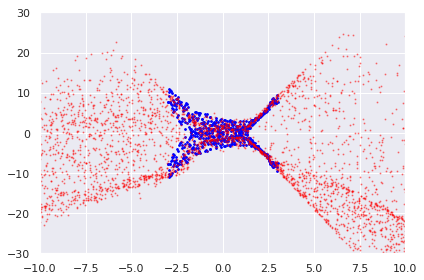

In [11]:
fig, ax = plt.subplots()
plt.xlim(-10,10)
plt.ylim(-30,30)
ax.scatter(x, y,s=3,color='blue')
scat = ax.scatter(list(np.linspace(-10,10, 300))*10,\
                       history[-1]\
                       ,s=1, alpha=0.4, color='red')
plt.tight_layout()
plt.show()

def update(i):
    ax.set_title('Iter:'+str(i+1))
    scat.set_offsets(np.transpose(np.array([list(np.linspace(-10,10, 300))*10,history[i]])))
    return scat,

In [12]:
anim = animation.FuncAnimation(fig, update,frames=len(history), interval=30, blit=True)

In [13]:
anim.save('./cde_with_gan.gif', writer='imagemagick', fps=10)

![alt text](./cde_with_gan.gif "segment")